# Hands-on Session for Real-Time Object Detection (OpenCV DNN + SSD MobileNet)

Instructor: [Yuxiao (Rain) Luo](https://yuxiaoluo.github.io)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YuxiaoLuo/AI_Intro/blob/main/week11_real_time_object_detection.ipynb)

This notebook demonstrates **real-time object detection** using OpenCV’s DNN module with a **pretrained SSD MobileNet model** trained on the **COCO** dataset.

You can run it on:
- a **webcam** (default), or
- a **video file** (e.g., `traffic.mp4`), see: [week11_Customized_ImageMining_1.ipynb](https://github.com/YuxiaoLuo/AI_Intro/blob/main/week11_Customized_ImageMining_1.ipynb).



> Notes
- `cv2.imshow()` works well in a local Jupyter environment that can open GUI windows.
- If you are in a headless environment (some servers / hosted notebooks), use the **inline display** option provided below.

## 1) Install dependencies (if needed)

If you already have these installed, you can skip this cell.

In [ ]:
pip install opencv-python opencv-python-headless opencv-contrib-python numpy matplotlib

In [ ]:
# If running in a fresh environment, uncomment and run:
# !pip install -U opencv-python numpy matplotlib
#
# If you're on a headless server (no GUI), you can use:
# !pip install -U opencv-python-headless numpy matplotlib

In [ ]:
'''if this code returns an error such as ""ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied:, 
Try the code below.'''

In [ ]:
pip install --user opencv-python opencv-python-headless opencv-contrib-python numpy matplotlib

## 2) Get the model files

You need:
- **Model weights**: `frozen_inference_graph.pb`
- **Model config**: `ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt`
- **Class labels**: `cocoLabels.txt` (80 COCO classes)

### Option A — Download automatically (if your notebook has internet)
Run the next cell.

### Option B — Manual
Place the three files in the same directory as this notebook, then skip the download cell. These files can be downloaded from our course GitHub repo: https://github.com/YuxiaoLuo/AI_Intro/tree/main/data/image_mining.

>Original sources:
>    - configuration file at https://gist.github.com/dkurt/54a8e8b51beb3bd3f770b79e56927bd7
>    - frozen_model file at https://github.com/datitran/object_detector_app/blob/master/object_detection/ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb
>    - cocoLabels file at https://github.com/amikelive/coco-labels/blob/master/coco-labels-2014_2017.txt

In [ ]:
# Download required files (requires internet access)
# You can modify these URLs if your course provides different hosting.

import os, urllib.request

urls = {
    "ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt": "https://gist.githubusercontent.com/dkurt/54a8e8b51beb3bd3f770b79e56927bd7/raw/ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt",
    "frozen_inference_graph.pb": "https://github.com/datitran/object_detector_app/raw/master/object_detection/ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb",
    "cocoLabels.txt": "https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-2014_2017.txt",
}

for fname, url in urls.items():
    if os.path.exists(fname):
        print(f"[OK] {fname} already exists")
        continue
    print(f"Downloading {fname} ...")
    urllib.request.urlretrieve(url, fname)
    print(f"[OK] Saved -> {fname}")

print("\nDone. Files in current directory:")
print("\n".join(sorted([f for f in os.listdir('.') if f.endswith(('.pb','.pbtxt','.txt'))])))

## 3) Load the model and labels

In [2]:
import cv2
import numpy as np

# Paths (edit if your files are elsewhere)
config_file = "data/image_mining/ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt"
frozen_model = "data/image_mining/frozen_inference_graph.pb"
labels_file = "data/image_mining/cocoLabels.txt"

# Load class labels
with open(labels_file, "rt") as f:
    classLabels = f.read().rstrip("\n").split("\n")

print(f"Loaded {len(classLabels)} labels. Example:", classLabels[:10])

# Load the model
model = cv2.dnn_DetectionModel(frozen_model, config_file)

# Set model input parameters (matches common SSD MobileNet preprocessing)
model.setInputSize(320, 320)
model.setInputScale(1.0/127.5)
model.setInputMean((127.5, 127.5, 127.5))
model.setInputSwapRB(True)

print("Model loaded and configured.")

Loaded 80 labels. Example: ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light']
Model loaded and configured.


## 4) Real-time detection (GUI window mode)

This mode uses `cv2.imshow()` and opens a window.
- Press **q** to quit.

If this doesn't work in your environment, use the **Inline mode** in the next section.

In [3]:
import cv2

# Choose input: set VIDEO_PATH=None to use webcam
VIDEO_PATH = None  # e.g., "link.mp4" or None for webcam

cap = cv2.VideoCapture(0 if VIDEO_PATH is None else VIDEO_PATH)

if not cap.isOpened():
    raise IOError("Cannot open video source. Check webcam permissions or video path.")

font = cv2.FONT_HERSHEY_PLAIN
font_scale = 2
thickness = 3

conf_threshold = 0.55

print("Starting... press 'q' in the video window to stop.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    class_ids, confidences, boxes = model.detect(frame, confThreshold=conf_threshold)

    if class_ids is not None and len(class_ids) > 0:
        for class_id, conf, box in zip(class_ids.flatten(), confidences.flatten(), boxes):
            if 1 <= class_id <= len(classLabels):
                x, y, w, h = box
                cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
                label = f"{classLabels[class_id-1]}: {conf:.2f}"
                cv2.putText(frame, label, (x, max(30, y-10)), font, font_scale, (0, 255, 0), thickness)

    cv2.imshow("Real-Time Object Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()
print("Stopped.")

Starting... press 'q' in the video window to stop.
Stopped.


## 5) Real-time detection (Inline mode for headless notebooks)

This mode displays frames *inside the notebook* (slower than a GUI window).

- Press the **stop button** in Jupyter to halt execution, or let it run for `MAX_FRAMES`.

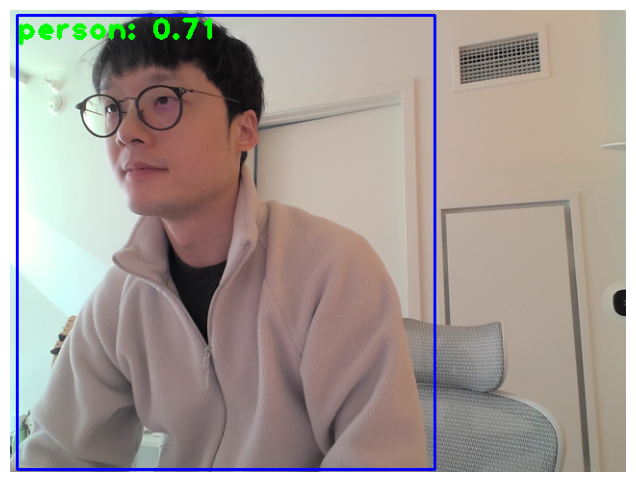

KeyboardInterrupt: 

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Choose input: set VIDEO_PATH=None to use webcam
VIDEO_PATH = None  # e.g., "link.mp4" or None for webcam

cap = cv2.VideoCapture(0 if VIDEO_PATH is None else VIDEO_PATH)

if not cap.isOpened():
    raise IOError("Cannot open video source. Check webcam permissions or video path.")

conf_threshold = 0.55
MAX_FRAMES = 300  # safety limit for inline rendering

frame_count = 0
print("Running inline detection...")

while frame_count < MAX_FRAMES:
    ret, frame = cap.read()
    if not ret:
        break

    class_ids, confidences, boxes = model.detect(frame, confThreshold=conf_threshold)

    if class_ids is not None and len(class_ids) > 0:
        for class_id, conf, box in zip(class_ids.flatten(), confidences.flatten(), boxes):
            if 1 <= class_id <= len(classLabels):
                x, y, w, h = box
                cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
                label = f"{classLabels[class_id-1]}: {conf:.2f}"
                cv2.putText(frame, label, (x, max(30, y-10)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)

    # Convert BGR -> RGB for matplotlib
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.imshow(rgb)
    plt.axis("off")
    plt.show()

    frame_count += 1

cap.release()
print("Done.")